In [32]:
import pandas as pd

# Load the dataset
df = pd.read_csv("/content/OneSWAM.merged.csv", encoding="ISO-8859-1")

# Preview the first few rows
df.head()


<ipython-input-32-0164432337da>:4: DtypeWarning: Columns (28,29,30,32,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/OneSWAM.merged.csv", encoding="ISO-8859-1")


,NIGP.Description,Item.Description,Order..,Order.Line.Number,Quantity.Ordered,Unit.Price,Unit.of.Measure,Line.Total,Line.Total.Change,Order.Status,...,NIGP..,Manufacturer.Part..,Most.Recent.Receiving.Date,PO.Category,Procurement.Transaction.Type,Contract.Number,Contract.Type,Registration.Type,VLIN.ID,SWAM.Merged
0,"Washers, Steel",5/16-18 X 3/8 BUTTONHEAD S/S,A711_P098953910-V2,6,100.00,0.2144,EA,21.44,0.23,Ordered,...,32091.0,0,0,0,0,0,0,0,0,1
1,"Household Furniture, General Line",LKS POWER/DATA CENTER BRUSHED CHR,A711_P098951880,6,16.00,199.0200,EA,3184.32,3184.32,Ordered,...,42040.0,0,0,0,0,0,0,0,0,0
2,"Counteractant and Degreaser, Odor",ULANO #3 SCREEN DEGREASER,PCO2466420,1,4.00,46.2200,GLL,184.88,184.88,Received,...,88546.0,0,0,0,0,0,0,0,0,1
3,"Silk Screened Shirts, Jackets, Hats, etc.",MG210 32 OZ. FREEDOM BOTTLE WITH PUSH-PULL LI...,PCO2796598,3,300.00,2.2000,EA,660.00,660.00,Ordered,...,20074.0,0,0,0,0,0,0,0,0,0
4,Courier/Delivery Services (Including Air Couri...,FOR MAILING OF DMV LICENSE PLATE,A711_P098958743,1,9461.64,1.0000,EA,9461.64,9461.64,Ordered,...,96224.0,0,0,0,0,0,0,0,0,0


# Part 1 explanation:
We start by importing the dataset into a pandas DataFrame. The .read_csv() function reads our file, and we use a special encoding to handle special characters. The .head() command helps us quickly view the top few rows to see what kind of data we're working with.

In [33]:
# Drop unnecessary or duplicate-identifying columns to reduce clutter
df = df.drop(columns=[
    'Order..', 'Order.Line.Number', 'Line.Total.Change',
    'Shipping.Name', 'Shipping.Lines', 'Shipping.Postal',
    'eVA.ID', 'Vendor.Address.Lines', 'Vendor.Address.Postal',
    'Manufacturer.Part..', 'Contract.Number', 'VLIN.ID'
])

# Convert order date from string to datetime format
df['Ordered.Date'] = pd.to_datetime(df['Ordered.Date'], errors='coerce')

# Remove rows that don't have a cost value
df = df.dropna(subset=['Line.Total'])

# Fill any other missing values with 'Unknown'
df = df.fillna('Unknown')


# Explanation:
We clean the data by removing irrelevant columns that don't help with cost prediction. Then we fix the date format and remove rows without cost values. Filling missing data with 'Unknown' ensures the model doesn’t crash later on.

In [ ]:
# Features used to predict cost
features = [
    'Quantity.Ordered', 'Unit.Price', 'Unit.of.Measure',
    'Item.Description', 'Vendor.Name', 'Shipping.State',
    'PO.Category', 'Order.Type'
]

# Target variable
target = 'Line.Total'

# Separate inputs and output
X = df[features]
y = df[target]


# Explanation:
We define which columns (features) will be used to predict cost, and specify that our target is Line.Total. This sets us up for training a machine learning model.

In [ ]:
from sklearn.preprocessing import LabelEncoder

X = X.copy()  # avoid SettingWithCopyWarning

# Encode object (text) columns
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype(str)  # force everything to be a string
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Explanation:
Machine learning models can’t work with text, so we use label encoding to turn all text-based columns into numbers. This step is needed for model training.

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (40000, 8)
Testing set shape: (10000, 8)


# Explanation:
We split our data so that the model can learn from one part and be tested on unseen data to measure performance. This helps us evaluate how well the model works.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model with 100 trees
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

# Explanation:
We use a Random Forest Regressor — a machine learning algorithm that makes predictions by combining many decision trees. It’s good for complex datasets like this one.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)

Mean Squared Error (MSE): 3945407328.8022733
R² Score: 0.09541819311439392


# Explanation:
We test our model by making predictions and comparing them to real values. The lower the MSE, the better. The R² score shows how well the model explains cost variation — closer to 1 is ideal.

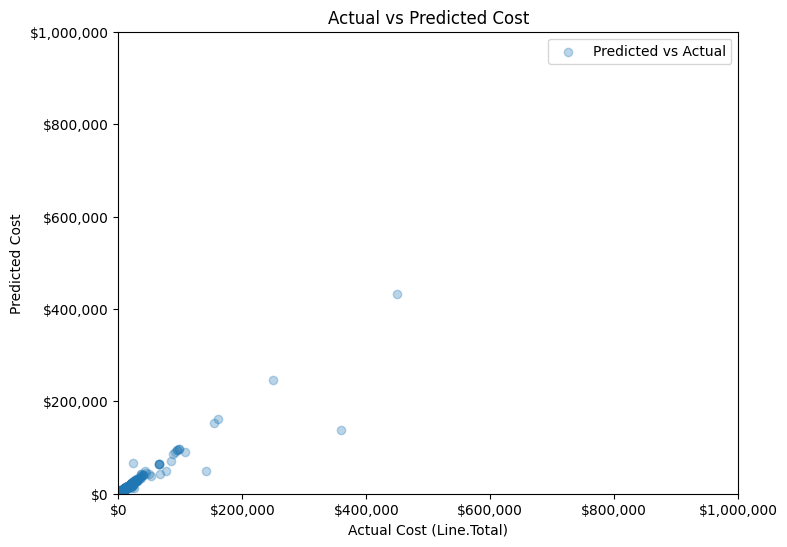

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  # <-- Add this import

# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3, label='Predicted vs Actual')
plt.xlabel("Actual Cost (Line.Total)")
plt.ylabel("Predicted Cost")
plt.title("Actual vs Predicted Cost")

# Format axis ticks as dollar values
formatter = ticker.FuncFormatter(lambda x, _: f'${x:,.0f}')
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Set axis limits (optional)
plt.xlim(0, 1_000_000)
plt.ylim(0, 1_000_000)

plt.legend()
plt.show()

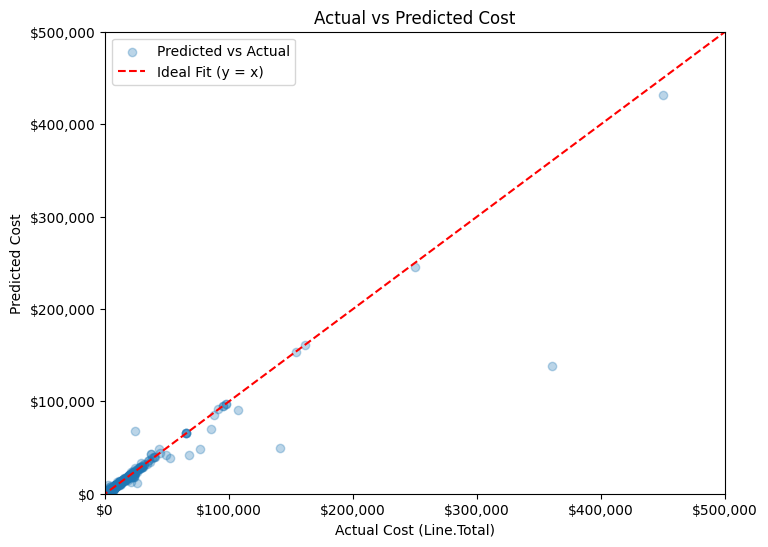

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3, label='Predicted vs Actual')

# Ideal line
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit (y = x)')

# Axis labels and title
plt.xlabel("Actual Cost (Line.Total)")
plt.ylabel("Predicted Cost")
plt.title("Actual vs Predicted Cost")

# Format axis as dollars
formatter = ticker.FuncFormatter(lambda x, _: f'${x:,.0f}')
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Set same limits for comparison
plt.xlim(0, 500_000)
plt.ylim(0, 500_000)

plt.legend()
plt.show()

These charts visually compare actual procurement costs with predicted costs, helping prison system stakeholders make smarter, data-driven decisions. Each point represents a real purchase, such as supplies or equipment. The red dashed line represents what a perfect prediction would look like. When predicted costs fall far from this line, it may signal overspending, vendor issues, or budgeting errors. Procurement teams can use this to spot unusually high-cost items, while finance staff can better plan budgets based on more reliable cost forecasting. Overall, these visuals help identify inefficiencies, reduce waste, and improve accountability, which are key goals for operating within strict public sector budgets.

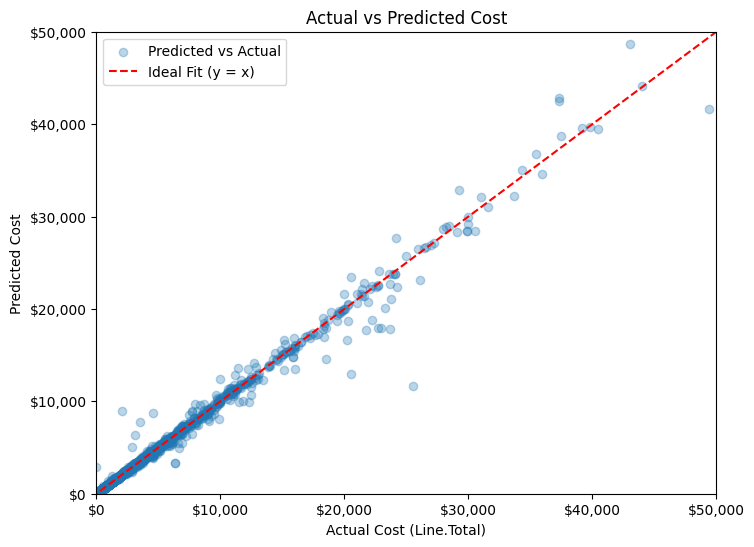

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3, label='Predicted vs Actual')

# Ideal line
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit (y = x)')

# Axis labels and title
plt.xlabel("Actual Cost (Line.Total)")
plt.ylabel("Predicted Cost")
plt.title("Actual vs Predicted Cost")

# Format axis as dollars
formatter = ticker.FuncFormatter(lambda x, _: f'${x:,.0f}')
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Set same limits for comparison
plt.xlim(0, 50_000)
plt.ylim(0, 50_000)

plt.legend()
plt.show()